# Inverse Problems 

## Standard methods for inverse problems (Tikhonov regularization, SVD)

### Problem statement

We have an equation
$$
y=F(u)+\eta
$$
here 
* $u$ is *parameter* or *model*, we want to reconstruct it;
* $F$ is *forward* (or *direct*) model
* $\eta$ measurement errors, typically we do not know it.

The **inverse** problem is to find $u$ for the given (noisy) measurements $y$.

The problem is *well-posed* if it has the following properties
* **Existence**, for all data $y$ (from some set) there exists solution $u$;
* **Uniqueness**, for all data $y$ (from some set) the solution $u$ is unique; 
* **Stability**, the solution $u$ depends continuously on $y$.

Two basic concepts to solve **ill-posed** problems
* *Deterministic inversion*,  based on regularization methods;
* *Bayesian inversion methods*, compute a probability density for the parameter $u$ rather than a single solution.

### A deblurring 1D problem

Consider a toy deblurring problem, where
$$
F\colon [0,\,1]\to\mathbb R,
$$
defined by
$$
y(x)=
F[u](x)=\int_0^1k(x-\tau)u(\tau)\,\text d\tau,\qquad 0\leq x\leq1,
$$
here $k$ is Gaussian kernel
$$
k(x)=C\exp\left(-\frac{x^2}{2\sigma^2}\right).
$$
* The forward problem: Given the source function $u$ and the kernel $k$, determine the blurred image $y$.
* The inverse problem: Given the  blurred image $y$ and and kernel $k$, determine the source (original image) function $u$.

The inverse problem is **ill-posed**.

Indeed, consider a small perturbation $\delta u(x)=\varepsilon\sin(2\pi\omega x)$.
The corresponding perturbation
$$
\delta y
=F(u+\delta u)-F(u)
=\varepsilon\int_0^1k(x-\tau)\sin(2\pi\omega \tau)\,\text d\tau
$$
tends to zero as $\omega\to+\infty$.
Hence, the ratio between $\delta u$ and $\delta y$ can be arbitrary large, which means, that stability condition is not satisfied.

Lets illustrate this effect.
We will use midpoint quadrature with uniformly distributed points to calculate the integral, so our 
problem is reduced to solving the matrix equation
$$
\mathbf y=F_N \mathbf u
$$
where $\mathbf y$ and $\mathbf u$ are $N$-dimensional vector, $F_N$ is Toeplitz matrix.

In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from ipywidgets import interactive, interact, widgets
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.dpi': 300}
matplotlib.rcParams.update(params)
# matplotlib.rcParams.update({'font.size': 14})
# mpl.rcParams['figure.dpi'] = 300
np.random.seed(42)

def mid_linspace(start=0.0, stop=1.0, num=100):
    """
    RETURNS 
        points in the middle of intervals
    """
    res, h = np.linspace(start, stop, num, endpoint=False, retstep=True)
    return res + h/2


def gen_sys_mat(k, N=100, interval=1.0):
    A = np.empty((N, N))
    y = mid_linspace(0, interval, N)
    for i, x in enumerate(y):
        A[i] = k(x, y)

    A /= N
    return A


def gen_sys_mat_translate_inv(k, N=100, interval=1.0):
    A = np.empty((N, N))
    h = interval/N
    l = (N - 1)*h
    pnts = np.linspace(-l, l, 2*N-1, endpoint=True)
    kv = k(pnts)
    for i in range(N):
        A[N-i-1] = kv[i:i+N]

    A /= N
    return A


def make_Gauss(sigma=1, C=None):
    if C is None:
        C = 1.0/(sigma*np.sqrt(2*np.pi))

    def k_Gauss(x, y=0.0):
        return C*np.exp(-((x-y)**2)/(2*sigma**2))

    return k_Gauss


def input_func_(x):
    x_intrv = np.array([0, 0.3, 0.35, 0.45, 0.5, 0.7, 0.75, 0.94])
    return [lambda x: 0.0,
            lambda x: np.sin(70*x),
            lambda x: 0.0,
            lambda x: 2.0,
            lambda x: 0.0,
            lambda x: -3.0,
            lambda x: 0.0,
            lambda x: 1.5*np.sin(10*x),
            lambda x: 0.0,
            ][x_intrv.searchsorted(x)](x)


input_func = np.vectorize(input_func_)

N = 100
X_plot = np.linspace(-0.1, 1.1, 2**10)
X = mid_linspace(0, 1, N)
K = make_Gauss(sigma=0.03)
#A = gen_sys_mat_translate_inv(K, N=N)
A = gen_sys_mat(K, N=N)
y = A @ input_func(X)

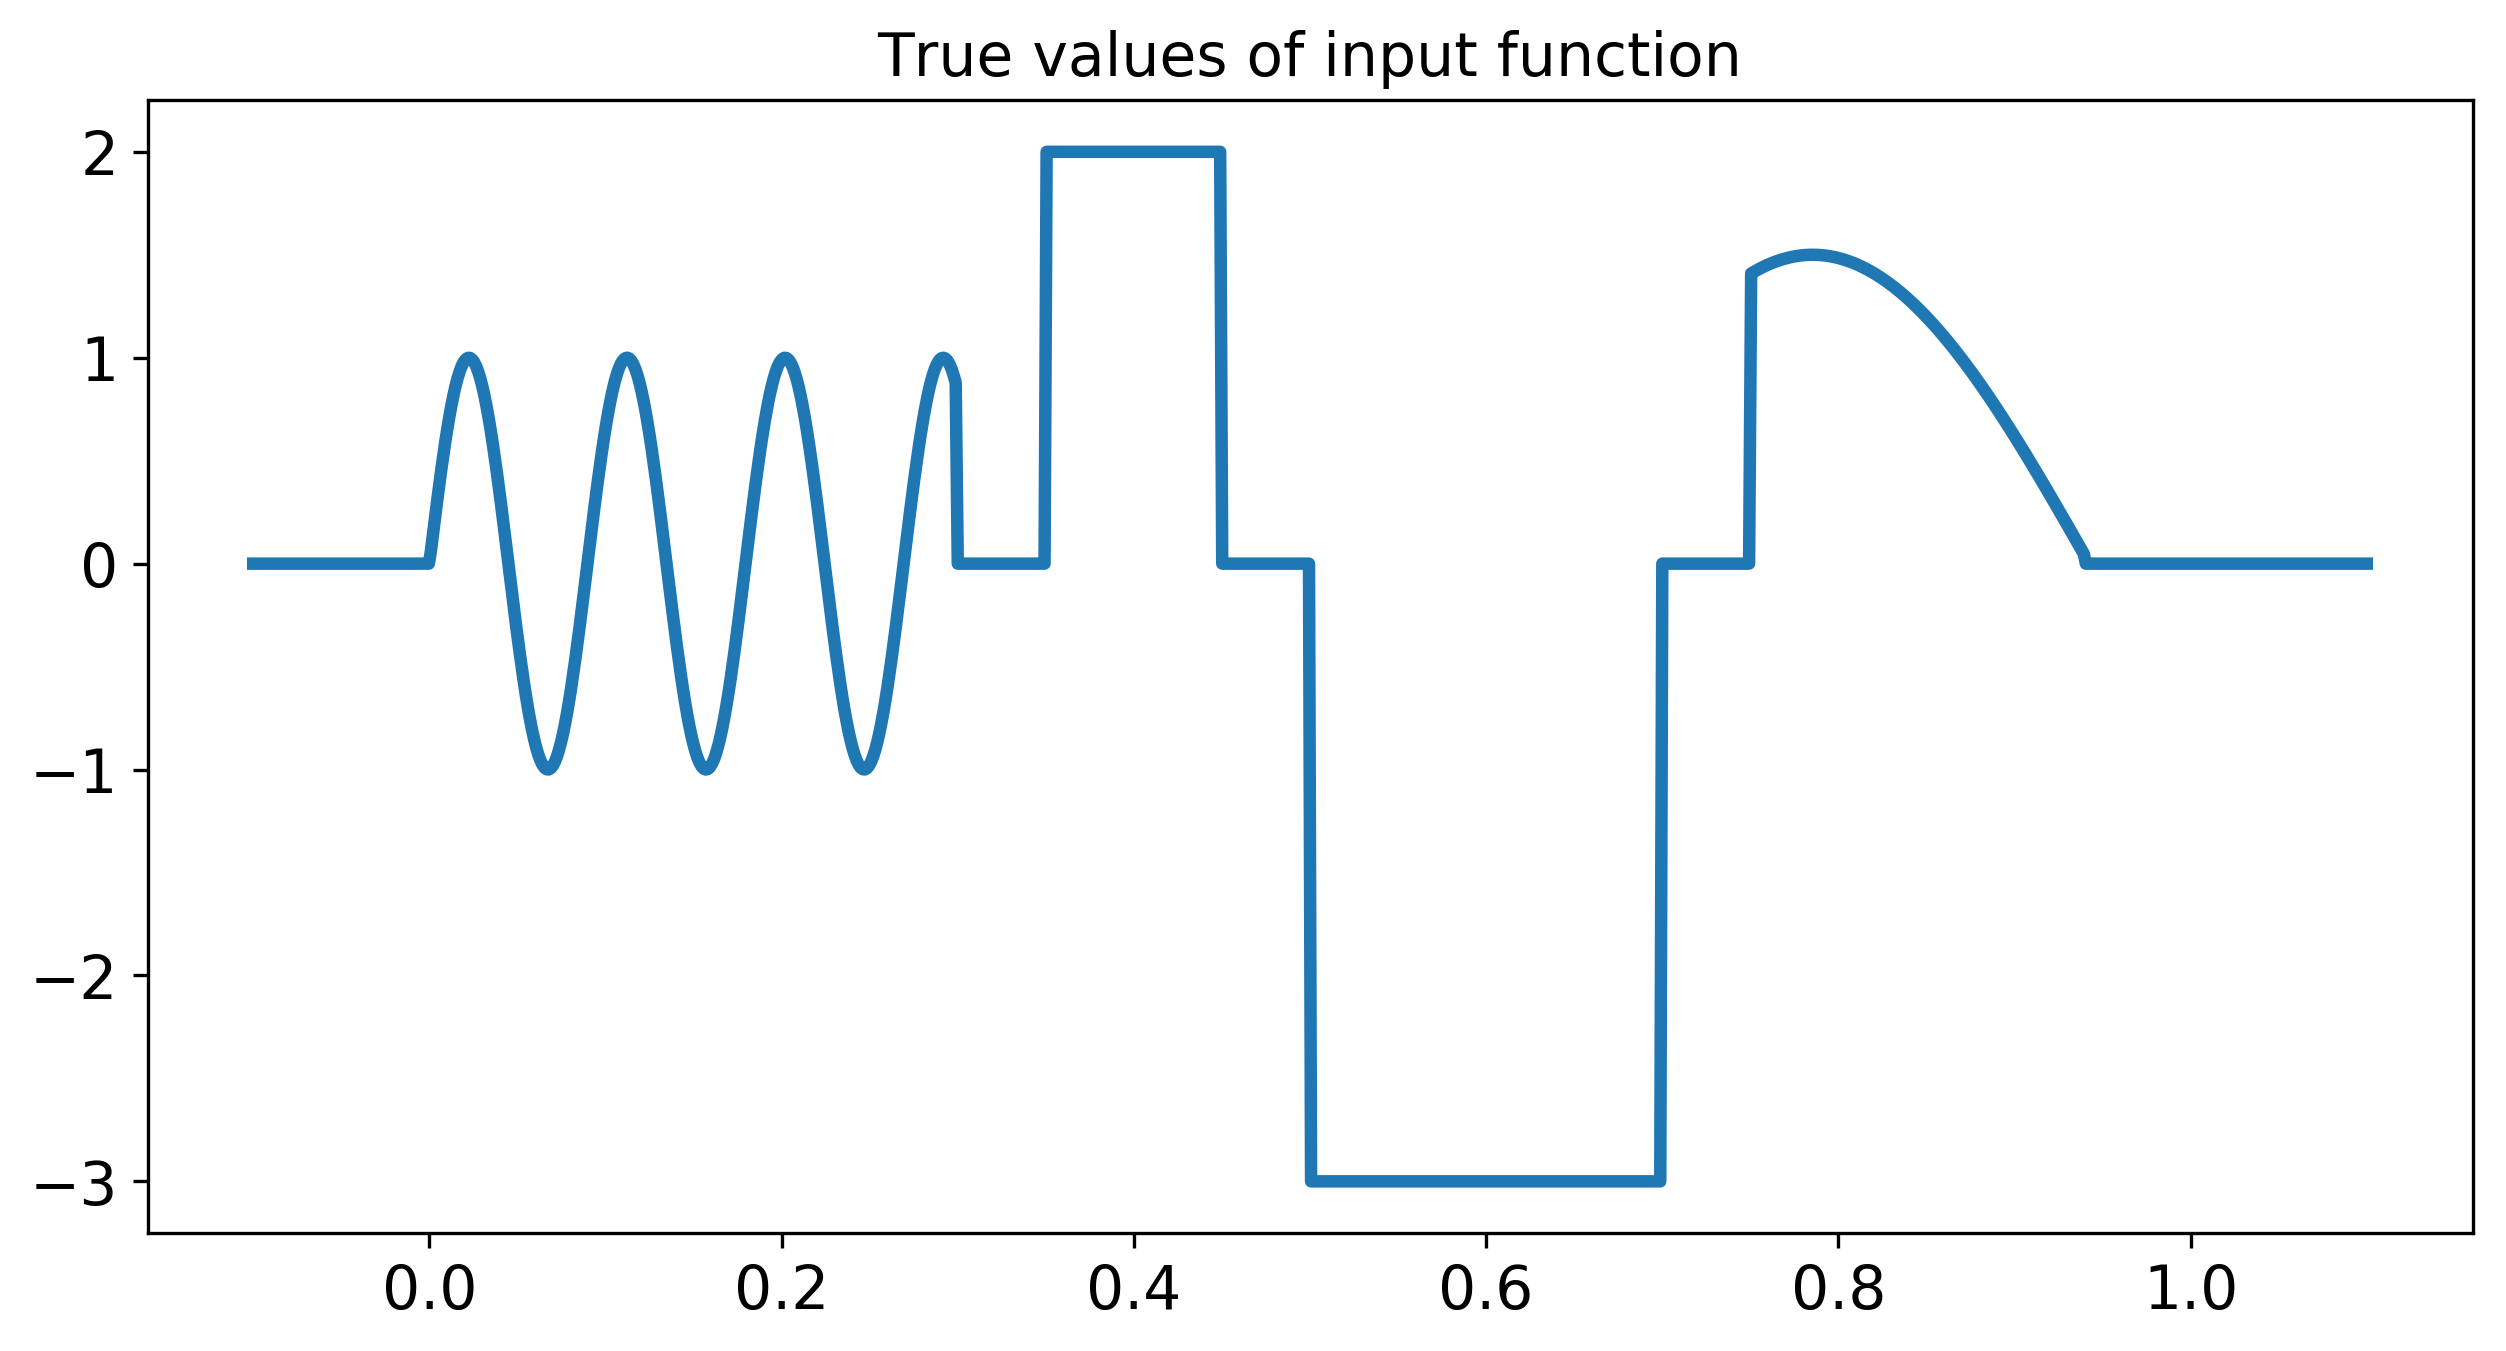

In [2]:
plt.plot(X_plot, input_func(X_plot), lw=3)
plt.title('True values of input function');

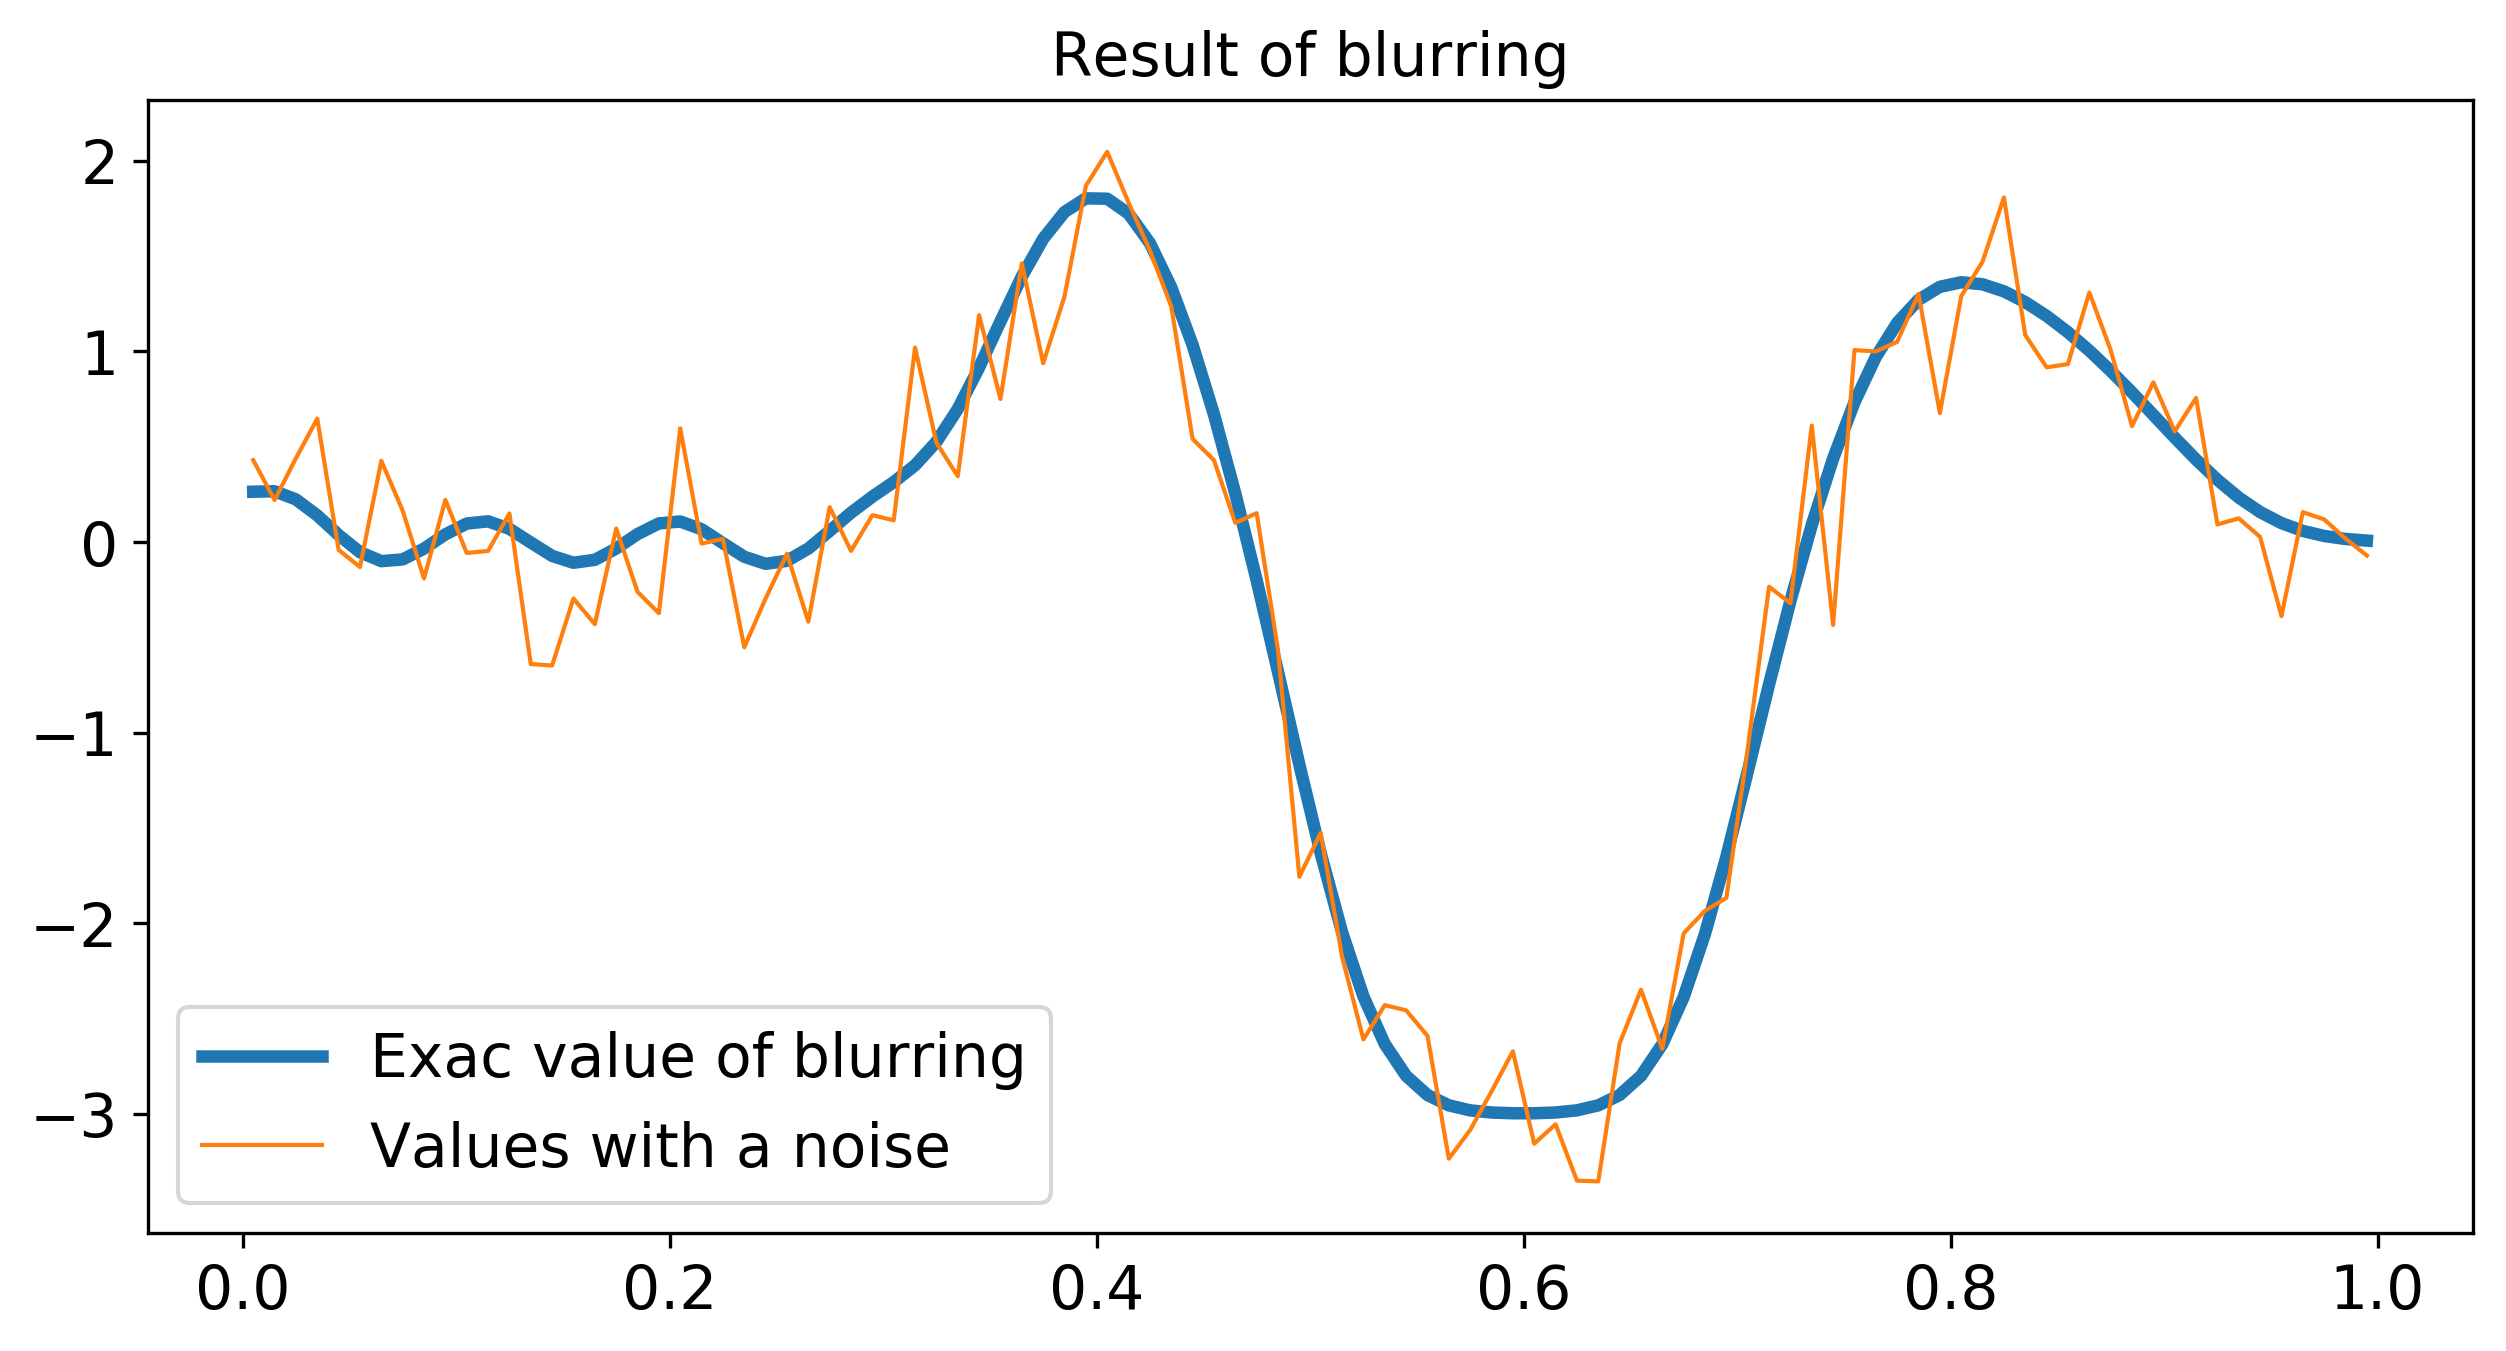

In [3]:
y = A @ input_func(X)
plt.plot(X, y, lw=3, label='Exac value of blurring')
plt.plot(X, y + np.random.randn(len(y))/3, lw=1, label='Values with a noise')
plt.title('Result of blurring');
plt.legend();

In [4]:
max_N = 150


def plot_inv(N, sigma=0):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    X = mid_linspace(0, 1, N)
    A = gen_sys_mat_translate_inv(K, N=N)
    y = A @ input_func(X)
    y += np.random.randn(len(y))*sigma/1e2
    p_sol = np.linalg.solve(A, y)
    ax1.plot(X, p_sol)
    ax1.set_title('restored function')
    ax2.set_ylabel(r'$p(x)$')
    ax1.set_xlabel('$x$')

    lambdas = np.linalg.svd(A, compute_uv=False)
    ax2.plot(lambdas, 'b.', ms=7)
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\sigma_i$', fontsize=20)
    ax2.set_xlabel(r'$i$')
    ax2.set_title('system matrix eigenvalues')
    ax2.set_ylim([1e-17, 1e1])
    ax2.set_xlim([0, max_N])


controls_rf = {'N': widgets.IntSlider(
    min=10, max=max_N, step=1, value=100, continuous_update=False, description='$N$'),
    'sigma': widgets.FloatSlider(
    min=0, max=1, step=0.01, value=0.0, continuous_update=False, description=r'$\sigma\times10^{-2}$')
}

In [5]:
interact(plot_inv, **controls_rf);

interactive(children=(IntSlider(value=100, continuous_update=False, description='$N$', max=150, min=10), FloatSlider(value=0.0, continuous_update=False, description='$\\sigma\\times10^{-2}$', max=1.0, step=0.01), Output()), _dom_classes=('widget-interact',))

We can see, that we can achieve a good result when $N\sim80$ with the case without noise.
If $N$ is larger, the quadrature approximates the integral better, but the inverse operator becomes worse. 
And the addition of a small noise spoils the whole picture.

How to avoid this?

### Regularization

Consider a SVD-decomposition of the matrix $F_N$
$$
F_N=U\Lambda V^T=\sum_{i=1}^N\sigma_iu_iv_i^T,
$$
where $\Lambda=\text{diag}(\sigma_1,\,\sigma_2,\,\ldots,\,\sigma_N)$

Our system matrix $F_N$ is symmetric positive defined as it is built with use of Gaussian kernel. 
Hence, SVD-decomposition and diagonal form coincide for it, $U=V$, and $\lambda_i=\sigma_i$,
but this fact will not be the key for our further reasoning.

The inverse acts as follows
$$
u=
F_N^{-1}y=V\Lambda^{-1} U^Ty=
\sum_{i=1}^N\sigma_i^{-1}(u_i^T,\,y)v_i.
$$
Instability goes from the small values of $\sigma$. The idea is to somehow 
tune small values of lambda so that their inverses do not significantly affect the result.  

We will add a regularizing factor $\omega(\sigma)$ to the formula for the inversion
$$
u\approx 
\sum_{i=1}^N\omega(\sigma^2)\sigma_i^{-1}(u_i^T,\,y)v_i.
$$

A popular choice for the filter function is truncation function
$$
\omega(\sigma^2)=
\left\{
\begin{align}
&1,&\text{if }\;\sigma^2&\geq\alpha,\\
&0,&\text{if }\;\sigma^2&<\alpha\\
\end{align}
\right..
$$
Here we just cut too small $\lambda$ values, and we get
$$
u_{\text{TSVD}}=
\sum_{\stackrel{\displaystyle i=1}{\displaystyle\sigma_i^2\geq\alpha}}^{\displaystyle N}\sigma_i^{-1}(u_i^T,\,y)v_i.
$$

An alternative is to use a smooth function
$$
\omega(\sigma^2)=\frac{\sigma^2}{\sigma^2+\alpha}.
$$
It is called *Tikhonov filter*.

We get
$$
u_{\text{TIK}}=
\sum_{i=1}^N\frac{\sigma_i}{\sigma_i^2+\alpha}(u_i^T,\,y)v_i.
$$

In [6]:
def plot_of_regur(alpha=0.1):
    L = np.linspace(0, 2, 2**10)
    plt.plot(L, (L**2>=alpha).astype(float), label='TSVD')
    plt.plot(L, L**2/(L**2 + alpha), label='Tikhonov');
    plt.title(r'Comparison of different $\omega$ with $\alpha={}$'.format(alpha));
    plt.xlabel(r'$\sigma$')
    plt.ylabel(r'$\omega(\sigma^2)$');
    plt.legend();

In [7]:
interact(plot_of_regur,
         alpha=widgets.FloatSlider(min=0.00001,max=1,step=.01,value=0.1,continuous_update=True,description=r'$\alpha$')
        );

interactive(children=(FloatSlider(value=0.1, description='$\\alpha$', max=1.0, min=1e-05, step=0.01), Output()), _dom_classes=('widget-interact',))

Actually, we can find $u_{\text{TIK}}$ without calculating SVD decomposition, which can be hard in the cases of huge matrix sizes.
Namely, regularization with Tikhonov filter can be defined as solution of the minimization problem
$$
u_{\text{TIK}}=
\mathop{\text{arg min}}_u\left(\frac12\|F_Nu-y\|_2^2+\frac\alpha2\|u\|_2^2\right),
$$
We can find this solution with use of iterative methods.

---

Let us show some examples of using different regularization strategies.

In [8]:
max_N = 150


def inv_SVD(A, y, alpha):
    u, s, vt = np.linalg.svd(A)
    res = np.zeros_like(y)
    for i, sigma in enumerate(s):
        if sigma**2 >= alpha:
            res += vt[i]/sigma*(u.T[i] @ y)

    return res


def inv_Tikh(A, y, alpha):
    u, s, vt = np.linalg.svd(A)
    res = np.zeros_like(y)
    for i, sigma in enumerate(s):
        res += sigma/(sigma**2 + alpha)*vt[i]*(u.T[i] @ y)

    return res


def plot_inv_reg(N, sigma=0, log_alpha=-20, method=['w/o regularization', 'SVD', 'Tikhonov']):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
    X = mid_linspace(0, 1, N)
    A = gen_sys_mat_translate_inv(K, N=N)
    y = A @ input_func(X)
    y += np.random.randn(len(y))*sigma/1e5

    alpha = 10**log_alpha
    if method[0] == 'S':
        p_sol = inv_SVD(A, y, alpha)
    elif method[0] == 'T':
        p_sol = inv_Tikh(A, y, alpha)
    else:
        p_sol = np.linalg.solve(A, y)
        #p_sol = np.linalg.lstsq(A, y)[0]

    ax1.plot(X, p_sol)
    ax1.set_title('restored function')
    ax2.set_ylabel(r'$\p(x)$')
    ax1.set_xlabel('$x$')

    lambdas = np.linalg.svd(A, compute_uv=False)
    ax2.plot(lambdas, 'b.', ms=7, label=r'$\{\sigma\}$')
    ax2.plot([0, max_N], [10**(log_alpha/2), 10**(log_alpha/2)],
             'r', label=r'$\sqrt{\alpha}$')
    ax2.set_yscale('log')
    ax2.set_ylabel(r'$\sigma_i$', fontsize=20)
    ax2.set_xlabel(r'$i$')
    ax2.set_title('system matrix eigenvalues')
    ax2.set_ylim([1e-17, 1e1])
    ax2.set_xlim([0, max_N])
    ax2.legend()


controls_reg = {'N': widgets.IntSlider(
    min=10, max=max_N, step=1, value=100, continuous_update=False, description='$N$'),
    'sigma': widgets.FloatSlider(min=0, max=1, step=0.01, value=0, continuous_update=False, description=r'$\sigma\times10^{-5}$'),
    'log_alpha': widgets.FloatSlider(min=-34, max=0, step=-.25, value=-13, continuous_update=False, description=r'$\log\alpha$'),
}

In [9]:
interact(plot_inv_reg, **controls_reg);

interactive(children=(IntSlider(value=100, continuous_update=False, description='$N$', max=150, min=10), FloatSlider(value=0.0, continuous_update=False, description='$\\sigma\\times10^{-5}$', max=1.0, step=0.01), FloatSlider(value=-13.0, continuous_update=False, description='$\\log\\alpha$', max=0.0, min=-34.0, step=-0.25), Dropdown(description='method', options=('w/o regularization', 'SVD', 'Tikhonov'), value='w/o regularization'), Output()), _dom_classes=('widget-interact',))

#### Error estimations
Let us estimate the error of the solution
$\def\utrue{u_{\text{true}}}$
$$
\varepsilon_\alpha:=
u_\alpha-\utrue=
F^{-1}_\alpha (F\utrue+\eta)-\utrue=
\varepsilon_\alpha^{\text{trunc}}+
\varepsilon_\alpha^{\text{noise}},
$$
where
$$
\varepsilon_\alpha^{\text{trunc}}:=
    F^{-1}_\alpha F\utrue=
\sum_{i=1}^{N}\bigl(\omega_\alpha(\sigma_i^2)-1\bigr)(u_i^T,\,\utrue)v_i,
$$
and
$$
\varepsilon_\alpha^{\text{noise}}:=
    F^{-1}_\alpha \eta=
\sum_{i=1}^{N}\omega_\alpha(\sigma_i^2)\sigma_i^{-1}(u_i^T,\,\eta)v_i.
$$

How to choose the alpha parameter so that both these errors tend to zero as the noise tends to zero?

Note that,$\def\norm|#1|{\left\|#1\right\|}$ 
* $\omega_\alpha(\sigma^2)\to1$ as $\alpha\to0$. So, $\varepsilon_\alpha^{\text{trunc}}\to0$ as $\alpha\to0$.
* we can check, that $\omega_\alpha(\sigma^2)\sigma^{-1}\leq\frac1{\sqrt\alpha}$ for both TSVD and Tikhonov. So,
$$
\norm|\varepsilon_\alpha^{\text{noise}}|\leq
\frac1{\sqrt\alpha}
\norm|\sum_{i=1}^N(u_i^T,\,\eta)v_i|=
\frac\delta{\sqrt\alpha}
$$
where $\delta=\norm|\eta|$.

Hence, if we choose $\alpha=\delta^p$ with $0<p<2$, both errors tend to 0:
$$
\varepsilon_\alpha\to0.
$$
This means that the TSVD and Tikhonov filters are **convergent**.

#### Choice of the $\alpha$

##### The $L$-curve criterion

In this method we calculate the solution with different $\alpha$ and plot the value of $\|Fu_\alpha-y\|$
against the value of $\|u_\alpha\|$.
This curve will be L-shaped.
The method tells us to take the value of $\alpha$ in the corner (point with largest curvature).

Let's see an example.

In [10]:
def sol_inv_reg(N, log_alpha, sigma=0., method='SVD'):
    np.random.seed(42)
    X = mid_linspace(0, 1, N)
    A = gen_sys_mat_translate_inv(K, N=N)
    y = A @ input_func(X)
    y += np.random.randn(len(y))*sigma/1e5

    alpha = 10**log_alpha
    if method[0] == 'S':
        p_sol = inv_SVD(A, y, alpha)
    elif method[0] == 'T':
        p_sol = inv_Tikh(A, y, alpha)
    else:
        p_sol = np.linalg.solve(A, y)
        
    return np.linalg.norm(p_sol, 2), np.linalg.norm(A @ p_sol - y, 2)

def plot_L_curve(N, sigma=0., method=['SVD','Tikhonov'], log_alpha_red=None):

    N_alpha = 100
    log_alpha = np.linspace(-40, 0, N_alpha)

    res = np.empty((N_alpha, 2))
    for i, la in enumerate(log_alpha):
        res[i] = sol_inv_reg(N, la, sigma=sigma, method=method)
        
    plt.plot(res[:, 1], res[:, 0]);
    plt.xscale('log')
    plt.yscale('log')
    if log_alpha_red is not None:
        res_red = sol_inv_reg(N, log_alpha_red, sigma=sigma, method=method)
        plt.plot(res_red[1], res_red[0], 'r+', ms=30);
        
    plt.xlabel(r'$||u_\alpha||$')
    plt.ylabel(r'$||Fu_\alpha-y||$')
    plt.title('L-curve')

        
controls_Lcv = {'N': widgets.IntSlider(
    min=10, max=max_N, step=1, value=100, continuous_update=False, description='$N$'),
    'sigma': widgets.FloatSlider(min=0, max=1, step=0.01, value=0, continuous_update=False, description=r'$\sigma\times10^{-5}$'),
    'log_alpha_red': widgets.FloatSlider(min=-34, max=0, step=-.25, value=-28, continuous_update=False, description=r'$\log\alpha$'),
}

In [11]:
interact(plot_L_curve, **controls_Lcv);

interactive(children=(IntSlider(value=100, continuous_update=False, description='$N$', max=150, min=10), FloatSlider(value=0.0, continuous_update=False, description='$\\sigma\\times10^{-5}$', max=1.0, step=0.01), Dropdown(description='method', options=('SVD', 'Tikhonov'), value='SVD'), FloatSlider(value=-28.0, continuous_update=False, description='$\\log\\alpha$', max=0.0, min=-34.0, step=-0.25), Output()), _dom_classes=('widget-interact',))

##### The discrepancy principle (Morozov).

In this method,
we choose the regularization parameter to be the largest value of $\alpha$ such that the norm of the misfit is bounded by the noise level in the data
$$
\alpha=\sup\bigl\{\alpha\colon \|Fu_\alpha-y\|<\delta\bigr\}
$$
where $\delta$ is the noise level.

In [12]:
def plot_M_curve(N, sigma=0., method=['SVD', 'Tikhonov'], delta=None):

    N_alpha = 100
    log_alpha = np.linspace(-40, 0, N_alpha)

    res = np.empty((N_alpha, 2))
    for i, la in enumerate(log_alpha):
        res[i] = sol_inv_reg(N, la, sigma=sigma, method=method)

    plt.plot(10**log_alpha, res[:, 1], lw=5)
    plt.xscale('log')
    plt.yscale('log')

    if delta is not None:
        plt.plot([10**min(log_alpha), 10**max(log_alpha)], [10**delta, 10**delta] , 'r-')
        found = res[:, 1].searchsorted(10**delta)
        plt.plot(10**log_alpha[found], 10**delta, 'ro', ms=10)
    
    plt.xlabel(r'$\alpha$')
    plt.ylabel(r'$||Fu_\alpha-y||$')
    plt.title('The discrepancy principle illustration')


controls_M = {'N': widgets.IntSlider(
    min=10, max=max_N, step=1, value=100, continuous_update=False, description='$N$'),
    'sigma': widgets.FloatSlider(min=0, max=1, step=0.01, value=0.2, continuous_update=False, description=r'$\sigma\times10^{-5}$'),
    'delta': widgets.FloatSlider(min=-10, max=2, step=0.25, value=-4.75, continuous_update=False, description=r'$\log\delta$'),
}

In [13]:
interact(plot_M_curve, **controls_M);

interactive(children=(IntSlider(value=100, continuous_update=False, description='$N$', max=150, min=10), FloatSlider(value=0.2, continuous_update=False, description='$\\sigma\\times10^{-5}$', max=1.0, step=0.01), Dropdown(description='method', options=('SVD', 'Tikhonov'), value='SVD'), FloatSlider(value=-4.75, continuous_update=False, description='$\\log\\delta$', max=2.0, min=-10.0, step=0.25), Output()), _dom_classes=('widget-interact',))

## Introduction to Bayesian Methods for Inverse Problems

Let us introduce the designations:

* Unknown parameters: $x\in\mathcal{X}\in\mathbb{R}^d$.
* Measurements: $y\in\mathcal{Y}\in\mathbb{R}^m$.
* Model: $f:\mathcal{X}\rightarrow \mathcal{Y}$.

Bayesian approach to inverse problems requires two components:

* A *prior* probability $p(x)$.
* And a *likelihood* $p(y\mid x, f)$.

As a rule, the likelihood form in general is:
$$
p(y\mid x, f) = p(y\mid f(x)).
$$
Gaussian is the most common:
$$
p(y\mid x,f,\sigma^2) = \mathcal{N}\left(y\mid f(x), \sigma^2I\right).
$$
In order to estimate $\sigma^2$, it is needed to introduce a prior probability $p(\sigma)$ as well.

Suppose that we have a Gaussian likelihood. Let's apply the Bayes rule now:
$$
p(x, \sigma^2\mid y, f) \propto p(y\mid x,f,\sigma^2)p(x)p(\sigma).
$$

This is *posterior state of knowledge* about all the parameters.
The problem here is to describe this probability density.

### Notes

* The solution to inverse problem with Bayesian approach is a distribution.
* The solution always exists.
* The solution is unique.
* The probability density of the posterior provides a quantification of uncertainties.

## Laplace Approximation
If you have a linear model and a Gaussian likelihood and the prior $p(x)$ is Gaussian, then this is just a Gaussian.
In general, it can be described through sampling or some approximation.

Let us discuss the Laplace approximation to the posterior. The Laplace approximation finds a Gaussian approximation to the posterior.

Let us assume that we know the value of $\sigma$. Our posterior is (for just $x$) is:
$$
p(x\mid y,\sigma) \propto p(y\mid x,\sigma)p(x) = \mathcal{N}\left(y\mid f(x),\sigma^2\right)p(x) \propto \exp\left\{-\frac{\parallel y - f(x) \parallel_2^2}{2\sigma^2}\right\}p(x).
$$

In order to implement the Laplace approximation let us define:
$$
L(x) = -\frac{\parallel y - f(x) \parallel_2^2}{2\sigma^2} + \log p(x).
$$
And now we need to find the maximum:
$$
\mu = \arg\max_{x\in\mathcal{X}} L(x),
$$
the covariance matrix
$$
\Sigma = -\left(\nabla^2 L(\mu)\right)^{-1},
$$
and the approximation is:
$$
p(x\mid y,\sigma) \approx \mathcal{N}(x\mid \mu,\Sigma).
$$

The second derivative:
$$
\frac{\partial ^2 L(\mu)}{\partial x_j \partial x_r} = \frac{1}{\sigma^2}\sum_{i=1}^m\frac{\partial f_i(\mu)}{\partial x_j}\frac{\partial f_i(\mu)}{\partial x_r}-\frac{1}{\sigma^2}\sum_{i=1}^m(y_i-f_i(\mu))\frac{\partial^2 f_i(\mu)}{\partial x_j\partial x_r} + \frac{\partial^2\log p(\mu)}{\partial x_r\partial x_j}.
$$

## Example: Catalytic Conversion of Nitrate to Nitrogen

Let us consider the the following example by [Prof. Ilias Bilionis, ME 59700 ](https://github.com/PredictiveScienceLab/uq-course/blob/master/handouts/handout_19.ipynb) and [(Tsilifis, 2014)](http://arxiv.org/abs/1410.5522).

Consider the catalytic
conversion of nitrate ($\mbox{NO}_3^-$) to nitrogen ($\mbox{N}_2$) and other
by-products by electrochemical means.
The mechanism that is followed is complex and not well understood.
The experiment of [(Katsounaros, 2012)](http://www.sciencedirect.com/science/article/pii/S0013468612005208) confirmed the
production of nitrogen ($\mbox{N}_2$), ammonia
($\mbox{NH}_3$), and nitrous oxide ($\mbox{N}_2\mbox{O}$) as final products
of the reaction, as well as the intermediate production of nitrite ($\mbox{NO}_2^-$).
The data are stored in
[catalysis.csv](catalysis.csv).
The time is measured in minutes and the conentrations are measured in $\mbox{mmol}\cdot\mbox{L}^{-1}$.
Let's load the data:

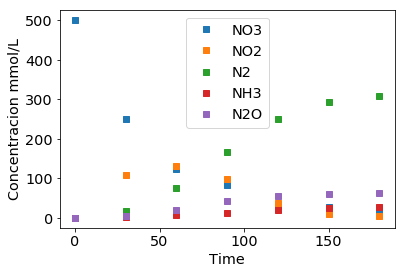

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#plt.figure(figsize=(11,9))
catalysis_data = pd.read_csv('catalysis.csv', index_col=0)
Y = catalysis_data[1:].get_values()
y = Y.flatten()
catalysis_data.plot(style='s')
plt.ylabel('Concentracion mmol/L')
plt.show()

The dynamical system associated with the reaction is:
$$
\begin{array}{cc}
\frac{d \left[\mbox{NO}_3^-\right]}{dt} &= -k_1\left[\mbox{NO}_3^-\right], \\
\frac{d\left[\mbox{NO}_2^-\right]}{dt} &= k_1\left[\mbox{NO}_3^-\right] - (k_2 + k_4 +
k_5)[\mbox{NO}_2^-], \\
\frac{d \left[\mbox{X}\right]}{dt} &= k_2 \left[\mbox{NO}_2^-\right] - k_3 [X],\\
\frac{d \left[\mbox{N}_2\right]}{dt} &= k_3 \left[\mbox{X}\right], \\
\frac{d \left[\mbox{NH}_3\right]}{dt} &= k_4 \left[\mbox{NO}_2^-\right],\\
\frac{d \left[\mbox{N}_2O\right]}{dt} &= k_5 \left[\mbox{NO}_2^-\right],
\end{array}
$$
where $[\cdot]$ denotes the concentration of a quantity, and
$k_i > 0$, $i=1,...5$ are the *kinetic rate constants*.

### Formulation of the Inverse Problem

#### Step 1: Making our life easier by simplifying the notation
Note that this is actually a linear system.
To simplify our notation, let's define:
$$
\begin{array}{ccc}
z_1 &:=& \left[\mbox{NO}_3^-\right],\\
z_2 &:=& \left[\mbox{NO}_2^-\right],\\
z_3 &:=& \left[\mbox{X}\right],\\
z_4 &:=& \left[\mbox{N}_2\right],\\
z_5 &:=& \left[\mbox{NH}_3\right],\\
z_6 &:=& \left[\mbox{N}_2O\right],
\end{array}
$$
the vector:
$$
z = (z_1,z_2,z_3,z_4,z_5,z_6),
$$
and the matrix:
$$
A(k_1,\dots,k_5) = \left(\begin{array}{cccccc}
-k_1 & 0 & 0 & 0 & 0 & 0\\
k_1 & -(k_2+k_4+k_5) & 0 & 0 & 0 & 0\\
0 & k_2 & -k_3 & 0 & 0 & 0\\
0 & 0 & k_3 & 0 & 0 & 0\\
0 & k_4 & 0 & 0 & 0 & 0\\
0 & k_5 & 0 & 0 & 0 & 0
\end{array}\right)\in\mathbb{R}^{6\times 6}.
$$
With these definitions, the dynamical system becomes:
$$
\dot{z} = A(k_1,\dots,k_5)z,
$$
with initial conditions
$$
z(0) = z_0 = (500, 0, 0, 0, 0, 0)\in\mathbb{R}^6,
$$
read directly from the experimental data.
What we are definitely going to need is a solver for this system.
That's easy.
Let's denote the solution of the system at time $t$ by:
$$
z(t;k_1,\dots,k_5).
$$

#### Step 2: Scale the unknown parameters to your best of your abilities
The constraints you have on your parameters, the better.
If you do have constraints, you would have to use constrained optimization algorithms.
The way you scale things depend on the problem.
Here we would think as follows:

+ $k_i$ has units of inverse time. It is proparly appropriate to scale it with the total time which is 180 minutes.
So, let's just multiply $k_i$ with 180. This makes the resulting variable dimensionless:
$$
\hat{x}_i = 180k_i.
$$

+ $k_i$ is positive, therefore $\hat{x_i}$ must be positive.
So, let's just work with the logarithm of $\hat{x_i}$:
$$
x_i = \log \hat{x_i} = \log 180k_i.
$$

+ define the parameter vector:
$$
x = (x_1,\dots,x_5)\in\mathcal{X} = \mathbb{R}^5.
$$

From now on, we will write
$$
A = A(x),
$$
for the matrix of the dynamical system, and
$$
z = z(t;x),
$$
for the solution at $t$ given that the parameters are $x$.

#### Step 3: Making the connection between our model and the experimental measurements
Our experimental data include measurements of everything except $z_3$ at times six (6) time instants:
$$
t_j = 30j\;\mbox{minutes},
$$
$j=1,\dots,6$.

Now, let $Y\in\mathbb{R}^{5\times 6}$ be the experimental measurements:

What is the connection between the solution of the dynamical system $z(t,x)$ and the experimental data?
It is as follows:
$$
\begin{array}{ccc}
z_1(30j;x) &\longrightarrow& Y_{j1},\\
z_2(30j;x) &\longrightarrow& Y_{j2},\\
z_4(30j;x) &\longrightarrow& Y_{j3},\\
z_5(30j;x) &\longrightarrow& Y_{j4},\\
z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$
for $j=1,\dots,6$.

We are now ready to define a function:
$$
f:\mathcal{X} \rightarrow \mathcal{Y}=\mathbb{R}^{30}_+,
$$
as follows:
+ Define the matrix function:
$$
F:\mathcal{X} \rightarrow \mathbb{R}^{5\times 6},
$$
by:
$$
\begin{array}{ccccc}
F_{j1}(x) &=& z_1(30j;x)&\longrightarrow& Y_{j1},\\
F_{j2}(x) &=& z_2(30j;x) &\longrightarrow& Y_{j2},\\
F_{j3}(x) &=& z_4(30j;x) &\longrightarrow& Y_{j3},\\
F_{j4}(x) &=& z_5(30j;x) &\longrightarrow& Y_{j4},\\
F_{j5}(x) &=& z_6(30j;x) &\longrightarrow& Y_{j5},
\end{array}
$$
+ And flatten that function:
$$
f(x) = \operatorname{vec}(F(x))\in\mathbb{R}^{30}.
$$

Now, we have made the connection with our theoretical formulation of inverse problems crystal clear.

## Example: The Laplace Approximation for the Catalysis Problem

Let us assume that $\sigma = 5$ and take
$$
p(x) = \mathcal{N}(0,\gamma^2I).
$$
We need this derivative:
$$
\nabla^2 \log p(x) = -\gamma^{-2}I.
$$

In [15]:
import numpy as np
import math
import scipy.stats as st
import scipy
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 300
import seaborn as sns
sns.set_style('white')
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')
from sys import *
from scipy.integrate import ode

In [16]:
def f1(t, y, A):
    """
    The normal dynamics and of the 1st derivatives wrt A.
    """
    d = A.shape[0]
    y_0 = y[:d]
    f_y_0 = f0(t, y_0, A)
    y_1 = y[d:d + d**3].reshape((d, d, d))
    f_y_1 = np.einsum('ij,jkl->ikl', A, y_1)
    for i in range(d):
        f_y_1[i, i, :] += y_0
    return np.hstack([f_y_0, f_y_1.flatten()])

def f2(t, y, A):
    """
    The normal dynamics and of the 2st derivatives wrt A.
    """
    d = A.shape[0]
    y_0 = y[:d]
    f_y_0 = f0(t, y_0, A)
    y_1 = y[d:d + d**3].reshape((d, d, d))
    f_y_1 = np.einsum('ij,jkl->ikl', A, y_1)
    for i in range(d):
        f_y_1[i, i, :] += y_0
    #return np.hstack([f_y_0, f_y_1.flatten()])
    y_2 = y[d+d**3:d+d**3+d**5].reshape((d,d**2,d**2))
    f_y_2 = np.einsum('ij,jkl->ikl',A, y_2)
    for i in range(d):
        for j in range(i*d,(i+1)*d):
            f_y_2[i,j,:] += y_1[j-i*d,:,:].flatten()
    for i in range(d):
        for j in range(i*d,(i+1)*d):
            f_y_2[i,:,j] += y_1[j-i*d,:,:].flatten()
    return np.hstack([f_y_0, f_y_1.flatten(), f_y_2.flatten()])
    


def df(kappa, y0, t):
    """
    Evaluate the derivative of the model derivatives at ``kappa`` and at times ``t``
    with initial conditions ``y0``.

    This returns a matrix of the following form:
    dy_1(t_1) / dkappa_1 ... dy_1(t_1) / dkappa_s
    ...
    dy_d(t_1) / dkappa_1 ... dy_d(t_1) / dkappa_s
    ...
    dy_1(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    ...
    dy_d(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    """
    A, dA = make_A(kappa)
    d = A.shape[0]
    r = ode(f1) # Look at system.py: this should be the f of the adjoint
    r.set_initial_value(np.hstack([y0, np.zeros((d ** 3, ))])).set_f_params(A)
    y_m = [r.y]
    for tt in t[1:]:
        r.integrate(tt)
        y_m.append(r.y[None, :])
    y_m = np.vstack(y_m)
    # This is the Jacobian with respect to the full matrix A
    J = y_m[:, d:].reshape((t.shape[0], d, d, d))
    # Now we apply the chain rule to compute the jacobian wrt kappa
    J_kappa = np.einsum('ijkl,klr', J, dA)
    return J_kappa.reshape((d * t.shape[0], kappa.shape[0]))


def f0(t, y, A):
    """
    The nomral dynamics.
    """
    return np.dot(A, y)


def make_A(kappa):
    """
    Make the matrix of the dynamical system from ``kappa``.
    """
    A = np.array([[-kappa[0], 0, 0, 0, 0, 0],
              [kappa[0], -kappa[1]-kappa[3]-kappa[4], 0, 0, 0, 0],
              [0, kappa[1], -kappa[2], 0, 0, 0],
              [0, 0, kappa[2], 0, 0, 0],
              [0, kappa[4], 0, 0, 0, 0],
              [0, kappa[3], 0, 0, 0, 0]])
    # The derivative of A with respect to kappa
    d = A.shape[0]
    s = kappa.shape[0]
    dA = np.zeros((d, d, s))
    dA[0, 0, 0] = -1.
    dA[1, 0, 0] = 1.
    dA[1, 1, 1] = -1.
    dA[1, 1, 4] = -1.
    dA[1, 1, 3] = -1.
    dA[2, 1, 1] = 1.
    dA[2, 2, 2] = -1.
    dA[3, 2, 2] = 1.
    dA[4, 1, 4] = 1.
    dA[5, 1, 3] = 1.
    return A, dA

def make_full_A(kappa):
    """
    Make the matrix of the dynamical system from ``kappa``.
    """
    assert kappa.shape[0] == 36
    A = kappa.reshape((6,6))
    dA = np.zeros((36,36))
    for i in range(36):
        dA[i,i] = 1
    dA = dA.reshape((6,6,36))
    return A, dA

def f(kappa, y0, t):
    """
    Evaluate the model at ``kappa`` and at times ``t`` with initial
    conditions ``y0``.

    It returns a flatten version of the system, i.e.:
    y_1(t_1)
    ...
    y_d(t_1)
    ...
    y_1(t_K)
    ...
    y_d(t_K)
    """
    A = make_A(kappa)[0]
    r = ode(f0)
    r.set_initial_value(y0, 0).set_f_params(A)
    y_m = [y0[None, :]]
    for tt in t[1:]:
        r.integrate(tt)
        y_m.append(r.y[None, :])
    y_m = np.vstack(y_m)
    return y_m.flatten()

def f_full(kappa, y0, t):
    """
    Evaluate the model at ``kappa`` and at times ``t`` with initial
    conditions ``y0``.

    It returns a flatten version of the system, i.e.:
    y_1(t_1)
    ...
    y_d(t_1)
    ...
    y_1(t_K)
    ...
    y_d(t_K)
    """
    A = make_full_A(kappa)[0]
    r = ode(f0)
    r.set_initial_value(y0, 0).set_f_params(A)
    y_m = [y0[None, :]]
    for tt in t[1:]:
        r.integrate(tt)
        y_m.append(r.y[None, :])
    y_m = np.vstack(y_m)
    return y_m.flatten()


def df2(kappa, y0, t):
    """
    Evaluate the derivative of the model derivatives at ``kappa`` and at times ``t``
    with initial conditions ``y0``.

    This returns a matrix of the following form:
    dy_1(t_1) / dkappa_1 ... dy_1(t_1) / dkappa_s
    ...
    dy_d(t_1) / dkappa_1 ... dy_d(t_1) / dkappa_s
    ...
    dy_1(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    ...
    dy_d(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    """
    A, dA = make_A(kappa)
    d = A.shape[0]
    r = ode(f2) # Look at system.py: this should be the f of the adjoint
    r.set_initial_value(np.hstack([y0, np.zeros((d ** 3 + d ** 5, ))])).set_f_params(A)
    y_m = [r.y]
    for tt in t[1:]:
        r.integrate(tt)
        y_m.append(r.y[None, :])
    y_m = np.vstack(y_m)
    # This is the Jacobian with respect to the full matrix A
    J = y_m[:, d:d+d**3].reshape((t.shape[0], d, d, d))
    # Now we apply the chain rule to compute the jacobian wrt kappa
    J_kappa = np.einsum('ijkl,klr', J, dA)
    
    J2 = y_m[:,d+d**3:d+d**3+d**5].reshape((t.shape[0], d, d**2, d**2))
    #print len(J2[0,0,0,:])
    ## Trying something New
    JJ = np.zeros((t.shape[0],d,kappa.shape[0],d**2))
    for j in range(t.shape[0]):
        for k in range(d):
            for i in range(d**2):
                JJ[j,k,:,i] = np.einsum('kl,klr',J2[j,k,i,:].reshape(d,d), dA)
    J_kappa2 = np.einsum('ijklr,lrs', JJ.reshape(t.shape[0],d,kappa.shape[0],d,d), dA)
    return J_kappa2.reshape((d * t.shape[0], kappa.shape[0], kappa.shape[0]))

def df2_full(kappa, y0, t):
    """
    Evaluate the derivative of the model derivatives at ``kappa`` and at times ``t``
    with initial conditions ``y0``.

    This returns a matrix of the following form:
    dy_1(t_1) / dkappa_1 ... dy_1(t_1) / dkappa_s
    ...
    dy_d(t_1) / dkappa_1 ... dy_d(t_1) / dkappa_s
    ...
    dy_1(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    ...
    dy_d(t_K) / dkappa_1 ... dy_d(t_K) / dkappa_s
    """
    A, dA = make_full_A(kappa)
    d = A.shape[0]
    r = ode(f2) # Look at system.py: this should be the f of the adjoint
    r.set_initial_value(np.hstack([y0, np.zeros((d ** 3 + d ** 5, ))])).set_f_params(A)
    y_m = [r.y]
    for tt in t[1:]:
        r.integrate(tt)
        y_m.append(r.y[None, :])
    y_m = np.vstack(y_m)
    # This is the Jacobian with respect to the full matrix A
    J = y_m[:, d:d+d**3].reshape((t.shape[0], d, d, d))
    # Now we apply the chain rule to compute the jacobian wrt kappa
    J_kappa = np.einsum('ijkl,klr', J, dA)
    
    J2 = y_m[:,d+d**3:d+d**3+d**5].reshape((t.shape[0], d, d**2, d**2))
    #print len(J2[0,0,0,:])
    ## Trying something New
    JJ = np.zeros((t.shape[0],d,kappa.shape[0],d**2))
    for j in range(t.shape[0]):
        for k in range(d):
            for i in range(d**2):
                JJ[j,k,:,i] = np.einsum('kl,klr',J2[j,k,i,:].reshape(d,d), dA)
    J_kappa2 = np.einsum('ijklr,lrs', JJ.reshape(t.shape[0],d,kappa.shape[0],d,d), dA)
    return J_kappa2.reshape((d * t.shape[0], kappa.shape[0], kappa.shape[0]))

def ndf2(kappa0, y0 ,t, h=1e-3):
    
    y = f(kappa0, y0, t)
    kappa = kappa0.copy()
    J = np.zeros((y.shape[0], kappa0.shape[0], kappa0.shape[0]))
    for i in range(kappa0.shape[0]):
        for j in range(kappa0.shape[0]):
            kappa[i] += h
            kappa[j] += h
            py1 = f(kappa, y0, t)
            kappa[j] -= 2*h
            py2 = f(kappa, y0 ,t)
            kappa[j] += 2*h
            kappa[i] -= 2*h
            py3 = f(kappa, y0, t)
            kappa[j] -= 2*h
            py4 = f(kappa, y0, t)
            kappa[i] += h
            kappa[j] += h 
            J[:, i, j] = (py1 - py2 - py3 + py4) / (4*h**2)
    return J




def view_as_column(x):
    """
    View x as a column vector.
    """
    if x.ndim == 1:
        x = x[:, None]
    elif x.ndim == 2 and x.shape[0] == 1:
        x = x.T
    return x


def solver(x):
        x = view_as_column(x)
        # Points where the solution will be evaluated
        t = np.array([0., 30., 60., 90., 120., 150., 180.])
        t = view_as_column(t)
        # Initial condition
        y0 = np.array([500., 0., 0., 0., 0., 0.])
        y0 = view_as_column(y0)
        sol = f(x[:,0], y0[:,0], t[:,0])
        J = df(x[:,0], y0[:,0], t[:,0])
        H = df2(x[:,0], y0[:,0], t[:,0])
        y = np.delete(sol.reshape((7,6)), 2, 1).flatten() # The 3rd species is unobserved
        dy = np.array([np.delete(J[:,i].reshape((7,6)), 2, 1).reshape(35) for i in range(J.shape[1])]) # Delete the 3rd species
        d2y = np.zeros((35, H.shape[1], H.shape[2]))
        for i in range(H.shape[1]):
            for j in range(H.shape[2]):
                d2y[:,i,j]= np.delete(H[:,i,j].reshape((7,6)), 2, 1).reshape(35) # Delete the 3rd species
        state = {}
        state['f'] = y
        state['f_grad'] = dy.T
        state['f_grad_2'] = d2y
        return state
    
Y = catalysis_data[1:].get_values()

# The experimental as a vector
y = Y.flatten()

# The model
#from demos.catalysis import CatalysisModel
#solver = CatalysisModel()  


# The loss function
def L_with_jac(x, y):
    k = np.exp(x) / 180.
    sol = solver(k)
    y = y / 500.
    f = sol['f'][5:] / 500
    dfdk = sol['f_grad'][5:, :] / 500.
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (f - y)
    dLdx = np.einsum('ij,i->j', dfdx, tmp)
    L = 0.5 * np.sum(tmp ** 2)
    return L, dLdx

# For making predictions
import scipy.integrate

def A(x):
    """
    Return the matrix of the dynamical system.
    """
    # Scale back to the k's
    k = np.exp(x) / 180.
    res = np.zeros((6,6))
    res[0, 0] = -k[0]
    res[1, 0] = k[0]
    res[1, 1] = -(k[1] + k[3] + k[4])
    res[2, 1] = k[1]
    res[2, 2] = -k[2]
    res[3, 2] = k[2]
    res[4, 1] = k[4]
    res[5, 1] = k[3]
    return res
    

def g(z, t, x):
    """
    The right hand side of the dynamical system.
    """
    return np.dot(A(x), z)


# The full solution of the dynamical system
def Z(x, t):
    """
    Returns the solution for parameters x at times t.
    """
    # The initial conditions
    z0 = np.array([500., 0., 0., 0., 0., 0.])
    return scipy.integrate.odeint(g, z0, t, args=(x,)) 

# The function that we need to maximize
def minus_log_post(x, y, sigma, gamma):
    k = np.exp(x) / 180.
    sigma = sigma
    sol = solver(k)
    f = sol['f'][5:]
    dfdk = sol['f_grad'][5:, :]
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    tmp = (y - f)
    dLdx = -np.einsum('ij,i->j', dfdx, tmp) / sigma ** 2 + x / gamma ** 2
    L = 0.5 * np.sum(tmp ** 2) / sigma ** 2 + 0.5 * np.sum(x ** 2) / gamma ** 2
    return L, dLdx


# The inverse of the second derivative
def compute_post_cov(mu, y, sigma, gamma):
    k = np.exp(mu) / 180.
    sol = solver(k)
    f = sol['f'][5:]
    dfdk = sol['f_grad'][5:, :]
    d2fdk2 = sol['f_grad_2'][5:, :, :]
    # Chain rule
    dfdx = np.einsum('ij,j->ij', dfdk, k)
    # Chain rule
    d2fdx2 = np.einsum('ijr,j,r->ijr', d2fdk2, k, k) + \
        np.einsum('ij,j,jr->ijr', dfdk, k, np.eye(k.shape[0]))
    tmp = (y - f)
    d2Ldx2 = - np.einsum('i,ijr->jr', tmp, d2fdx2) / sigma ** 2 \
             + np.einsum('ij,ir->jr', dfdx, dfdx) / sigma ** 2  \
             + np.eye(mu.shape[0]) / gamma ** 2
    # We need to invert this to see our Sigma:
    Sigma = np.linalg.inv(d2Ldx2) # We should not ever invert - but we make an exception here
    return Sigma

In [17]:
# sigma choice
sigma = 10. # Variance of noise

# gamma choice
gamma = 10.

# Initial guess for x
np.random.rand(1)
x0 = np.random.randn(5)

# Minimize the loss function
res_la = scipy.optimize.minimize(minus_log_post, x0, jac=True, args=(y, sigma, gamma), method='BFGS', options={'maxiter': 10})

print(res_la)

# The mean of the x's:
mu = res_la.x

# The covariance matrix of the x's:
Sigma = compute_post_cov(mu, y, sigma, gamma)

      fun: 22.746863258996896
 hess_inv: array([[  5.4081046496e-04,  -5.8694392292e-05,  -9.3704931418e-04,  -9.3256239116e-04,  -6.3465876188e-04],
       [ -5.8694392292e-05,   3.1082092190e-03,  -1.7206618137e-03,   1.3801242934e-03,   7.1170223378e-03],
       [ -9.3704931418e-04,  -1.7206618137e-03,   7.0494549748e-03,   7.6875455844e-03,   4.8601638129e-03],
       [ -9.3256239116e-04,   1.3801242934e-03,   7.6875455844e-03,   2.3750850353e-02,   1.8426329198e-02],
       [ -6.3465876188e-04,   7.1170223378e-03,   4.8601638129e-03,   1.8426329198e-02,   4.4661215504e-02]])
      jac: array([ 24.5749343607,  27.2050015275,  -9.3893496717,   7.1545171538,  -1.8404379706])
  message: 'Maximum number of iterations has been exceeded.'
     nfev: 17
      nit: 10
     njev: 17
   status: 1
  success: False
        x: array([ 1.3981260416,  1.8190383632,  1.1456891369, -0.0670860229, -1.2366458007])


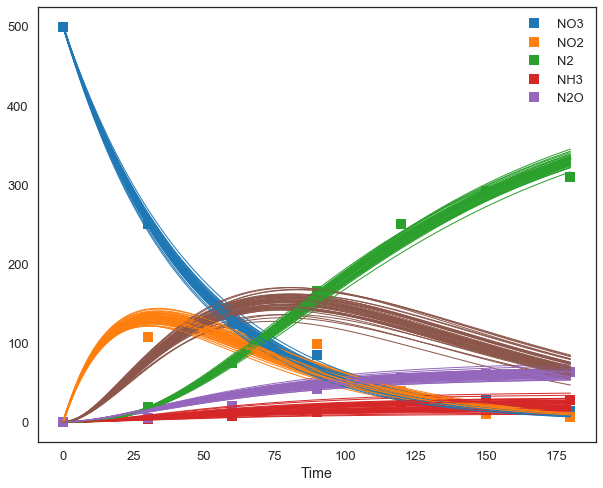

In [18]:
# Let's visualize the uncertainty about the response by taking some samples
num_samples = 50
t = np.linspace(0, 180, 200)
fig, ax = plt.subplots(figsize=(10, 8))
catalysis_data.plot(ax=ax, style='s')
Yp = Z(mu, t)
ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], label='Model NO3-')
ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], label='Model NO2-')
ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], label='Model X')
ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], label='Model N2')
ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], label='Model NH3')
ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], label='Model N2O')
for i in range(num_samples): # Take a sample from the posterior
    x = np.random.multivariate_normal(mu, Sigma)
    Yp = Z(x, t)
    ax.plot(t, Yp[:, 0], color=sns.color_palette()[0], lw=1, label='Model NO3-')
    ax.plot(t, Yp[:, 1], color=sns.color_palette()[1], lw=1, label='Model NO2-')
    ax.plot(t, Yp[:, 2], color=sns.color_palette()[5], lw=1, label='Model X')
    ax.plot(t, Yp[:, 3], color=sns.color_palette()[2], lw=1, label='Model N2')
    ax.plot(t, Yp[:, 4], color=sns.color_palette()[3], lw=1, label='Model NH3')
    ax.plot(t, Yp[:, 5], color=sns.color_palette()[4], lw=1, label='Model N2O')